In [10]:
import os 
from glob import glob
from functools import reduce 
import math
import numpy as np
from scipy.stats import gaussian_kde, linregress

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import xarray as xr
import pandas as pd
from SALib.analyze import delta

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 12
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cm_data = np.loadtxt("./utils/colormaps/batlow.txt")[::-1]
sc_cmap = LinearSegmentedColormap.from_list("cmap", cm_data, N=10)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from utils.global_paths import project_data_path, project_code_path, loca_path
from utils.constants import location_names, location_coords, obs_colors, obs_names

In [11]:
# Info 
subset_name = 'eCONUS'

# Soil labels for plots
soil_labels = {"mean-change": "Annual average soil moisture \n(change from historical)", 
               "5dmin-change": "Soil moisture during driest 5 days \n(change from historical)",
               "5dmax-change": "Soil moisture during wettest 5 days \n(change from historical)",
               "days_above_q95": "Number of days above historical 95th percentile",
               "days_below_q05": "Number of days below historical 5th percentile",
               "days_above_q99": "Number of days above historical 99th percentile",
               "days_below_q01": "Number of days below historical 1st percentile",
               "mean": "Annual average \nsoil moisture", 
               "5dmin": "Soil moisture \nduring driest 5 days",
               "5dmax": "Soil moisture \nduring wettest 5 days"}

soil_labels_short = {"mean-change": "Annual average", 
                     "5dmin-change": "Driest 5 days",
                     "5dmax-change": "Wettest 5 days",
                     "days_below_q05": "Dry day frequency",
                     "days_above_q95": "Wet day frequency",
                     "days_below_q01": "Dry day frequency",
                     "days_above_q99": "Wet day frequency",}

# Index labels for SA plot
index_labels = {'ssp':'Emissions \nscenario',
                'model':'Climate \nmodel',
                'time':'Inter-annual \nvariability',
                'obs_name':'Soil \nproduct',
                'loss_metric':'Loss \nfunction',
                'soil_id':'Hydrologic \nparameters'}

index_labels_simple = {'ssp':'Scenario',
                       'model':'GCM',
                       'time':'Variability',
                       'obs_name':'Obs. product',
                       'loss_metric':'Loss func.',
                       'soil_id':'Hydro. params'}

# SA colors
climate_color = 'cornflowerblue'
hydro_color = 'orange'

# Plot styles
ls_ssp = {'ssp245':'--', 'ssp370':'-'}

# Time slices to analyze
time_slices = [[2030, 2039], [2050,2059], [2080,2089]]

# SSPs
ssps = ['ssp245', 'ssp370']

In [3]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="20GiB",
    walltime="01:00:00"
)
cluster.scale(jobs=10)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)
client

<Client: 'tcp://10.6.8.77:46865' processes=0 threads=0, memory=0 B>

### Preliminaries

In [12]:
# Models 
models = os.listdir(f"{loca_path}/")
models.remove('training_data')
models.remove('scripts')

loca_all = {}

# Loop through models
for model in models:
    loca_all[model] = {}
    # Loop through members
    members = os.listdir(f"{loca_path}/{model}/0p0625deg/")
    for member in members:
        # Append SSPs
        all_ssps = os.listdir(f"{loca_path}/{model}/0p0625deg/{member}/")
        loca_all[model][member] = all_ssps

# Matches website (https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/) as of Jan 2023
print(f"# models: {len(models)}")
print(f"# model/expts: {np.sum([len(np.unique([item for row in [loca_all[model][member] for member in loca_all[model].keys()] for item in row])) for model in models])}")
print(f"# model/expts/ens: {np.sum([len(loca_all[model][ssp]) for model in models for ssp in loca_all[model]])}")
print(f"# model/expts/ens (not including historical): {np.sum([len([ssp for ssp in loca_all[model][member] if ssp != 'historical']) for model in models for member in loca_all[model]])}")

# models: 27
# model/expts: 99
# model/expts/ens: 329
# model/expts/ens (not including historical): 221


In [13]:
# Read all soil moisture metrics
def read_all(subset_name, soil_metric, ssps):
    # For all
    ds_all = []

    # Loop through models
    for model in models:
        # Take first member only
        for member in list(loca_all[model].keys())[:1]:
            # Loop through SSPs
            for ssp in loca_all[model][member]:
                if ssp in ssps:
                    projection_id = f"{model}_{member}_{ssp}"
                    ds_proj = []
                    # Loop through obs
                    for obs_name in obs_names:
                        # Concat along loss metrics
                        ds = xr.open_mfdataset(f"{project_data_path}/projections/{subset_name}/metrics/{soil_metric}/{projection_id}_{obs_name}_*.nc",
                                                combine="nested", concat_dim="loss_metric")
                        # Append
                        ds_proj.append(ds)
                    # Concat along obs
                    ds_proj = xr.concat(ds_proj, dim="obs_name")
                    ds_all.append(ds_proj)
                    
    # Concat along climate
    ds_all = xr.concat(ds_all, dim="projection_id")

    # Fix time dim
    ds_all['time'] = ds_all['time'].dt.year

    return ds_all

In [14]:
# Calculate delta indexes using SAlib
def get_delta_single(df_loc, soil_metric, sa_factors):
    # Shuffle otherwise incorrect
    df = df_loc.sample(frac = 1)
    
    # Problem def
    n_factors = len(sa_factors)
    
    problem = {
        'num_vars': n_factors,
        'names': sa_factors,
    }

    # Do it
    X = df[sa_factors].to_numpy()
    Y = df[soil_metric].to_numpy()
    Si = delta.analyze(problem, X, Y).to_df()
    
    # Add normalized results
    Si['delta_norm'] = Si['delta'] / Si['delta'].sum()
    Si['delta_norm_conf'] = Si['delta_conf'] / Si['delta'] * Si['delta_norm']
    
    return Si

In [15]:
# Plotting function
def plot_sa_single(Si, names, climate_color, hydro_color, legend, ylabel, xlabels, rotation, fs, ax, index_labels=index_labels):
    # Plot style
    index_colors = {'ssp':climate_color,
                    'model':climate_color,
                    'time':climate_color,
                    'obs_name':hydro_color,
                    'loss_metric':hydro_color,
                    'soil_id':hydro_color}

    # Make plot
    Si.plot.bar(ax=ax, y ='delta_norm', yerr='delta_norm_conf', 
                color=[index_colors[name] for name in names])

    if ylabel:
        ax.set_ylabel('Delta sensitivity index')
    else:
        ax.set_ylabel('')
        
    ax.set_yticklabels('')
            
    if xlabels:
        ax.set_xticks(ticks = np.arange(len(names)),
                      labels=[index_labels[name] for name in names],
                      rotation=rotation, fontsize=fs)
    else:
        ax.set_xticklabels('')

    custom_lines = [Line2D([0], [0], color=climate_color, lw=4),
                    Line2D([0], [0], color=hydro_color, lw=4)]
    if legend: 
        ax.legend(custom_lines, ['Climate', 'Hydrology'], handlelength=1)
    else:
        ax.legend().remove()

    ax.grid(alpha=0.5)
    ax.set_axisbelow(True)

# Trends

### Functions

In [16]:
# Read all for single location
def read_loc_all(soil_metric, lat, lon):
    # Load and select gridpoint
    ds = read_all(subset_name, soil_metric, ssps)
    ds_loc = ds.sel(lat=lat, lon=lon, method='nearest').load()
    return ds_loc.to_dataframe().reset_index()

In [17]:
# Function to get trends
def get_trends(df, soil_metric):
    # Get linear trends
    def linear_fit(df):
        y = df[soil_metric].to_numpy()
        X = df['time'].to_numpy()
        slope, intercept, r, p_less, se = linregress(X, y, alternative='less')
        slope, intercept, r, p_greater, se = linregress(X, y, alternative='greater')
        return slope, p_less, p_greater

    # Get trends
    trends = df.groupby(['soil_id', 'projection_id']).apply(linear_fit, include_groups=False)

    # Plot
    df_trends = pd.DataFrame({'slope_p': trends}).reset_index()
    
    df_trends['trend'] = 10 * df_trends['slope_p'].apply(lambda x: x[0]) # change per decade 
    df_trends['p_less'] = df_trends['slope_p'].apply(lambda x: x[1])
    df_trends['p_greater'] = df_trends['slope_p'].apply(lambda x: x[2])
    df_trends.drop(columns = 'slope_p', inplace=True)
    
    df_trends['obs_name'] = df_trends['soil_id'].apply(lambda x: x.split('_')[0])
    df_trends['loss_metric'] = df_trends['soil_id'].apply(lambda x: x.split('_')[1])
    df_trends['ssp'] = df_trends['projection_id'].apply(lambda x: x.split('_')[-1])
    df_trends['model'] = df_trends['projection_id'].apply(lambda x: x.split('_')[0])
    return df_trends

In [18]:
# Plot trends probability density function
def plot_trend_pdf(df_trends, fs, xlabel, ax):
    # Plot
    for obs_name in obs_names:
        for ssp in ssps:
            df_tmp = df_trends[(df_trends['ssp'] == ssp) & (df_trends['obs_name'] == obs_name)]['trend']
            df_tmp.plot.kde(color=obs_colors[obs_name], ls=ls_ssp[ssp], ax=ax)

    ax.set_xlim([df_trends['trend'].min(),df_trends['trend'].max()])
    ax.grid(alpha=0.5)
    ax.set_yticklabels('')
    ax.set_xlabel(f'Trend {xlabel}', fontsize=fs)
    ax.set_ylabel('', fontsize=fs)

In [19]:
# Stylized boxplot
def custom_bxp(data, x, color, ls, ax):
    data_mean = data.median()
    data_q975 = np.quantile(data, 0.975)
    data_q025 = np.quantile(data, 0.025)
    # data_max = data.max()
    # data_min = data.min()

    # Plot
    ax.scatter([x], [data_mean], color=color, s=10)
    ax.plot([x,x], [data_q025, data_q975], lw=2, color=color, ls=ls)
    # ax.plot([x,x], [data_min, data_max], lw=1.5, color=color, ls=ls)

In [20]:
# Plot time series of stylized boxplot
def timeseries_bxp(df, soil_metric, fs, ylabel, ax):
    decades = np.arange(2035, 2099, 20)
    for year in decades:
        spacer = 0 # x axis spacer
        for obs_name in obs_names:
            spacer+=1
            for ssp in ssps:
                year_margin = 5 # how many years to include either side of central year
                data = df[(df['obs_name'] == obs_name) & (df['ssp'] == ssp) & (df['time'] >= (year-year_margin)) & (df['time'] <= (year+year_margin))][soil_metric]
                custom_bxp(data=data, x=year+spacer-6, color=obs_colors[obs_name], ls=ls_ssp[ssp], ax=ax)
                spacer+=1

    ax.grid(alpha=0.5)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_xticks(decades, [f"{decade}" for decade in decades-5], fontsize=fs)

In [21]:
def trend_plot_single_loc(location_name, sa_factors, save_path):
    # Get loc
    lat, lon = location_coords[location_name] 
    
    # Mean
    soil_metric = 'mean'
    df_mean = read_loc_all(soil_metric, lat, lon)
    df_mean_trends = get_trends(df_mean, soil_metric)
    df_mean_trends_Si = get_delta_single(df_mean_trends, 'trend', sa_factors)
    
    # 5dmin
    soil_metric = '5dmin'
    df_5dmin = read_loc_all(soil_metric, lat, lon)
    df_5dmin_trends = get_trends(df_5dmin, soil_metric)
    df_5dmin_trends_Si = get_delta_single(df_5dmin_trends, 'trend', sa_factors)
    
    # 5dmax
    soil_metric = '5dmax'
    df_5dmax = read_loc_all(soil_metric, lat, lon)
    df_5dmax_trends = get_trends(df_5dmax, soil_metric)
    df_5dmax_trends_Si = get_delta_single(df_5dmax_trends, 'trend', sa_factors)
    
    # q05
    soil_metric = 'days_below_q05'
    df_q05 = read_loc_all(soil_metric, lat, lon)
    df_q05_trends = get_trends(df_q05, soil_metric)
    df_q05_trends_Si = get_delta_single(df_q05_trends, 'trend', sa_factors)
    
    # q95
    soil_metric = 'days_above_q95'
    df_q95 = read_loc_all(soil_metric, lat, lon)
    df_q95_trends = get_trends(df_q95, soil_metric)
    df_q95_trends_Si = get_delta_single(df_q95_trends, 'trend', sa_factors)

    ##################
    # Make plot
    ##################
    fig = plt.figure(layout='constrained', figsize=(10, 12))
    subfigs = fig.subfigures(6, 1, hspace=0.05, height_ratios = [5,5,5,5,5,1])
    
    width_ratios = [2,1,1.2]

    fig.suptitle(location_names[location_name], fontweight='bold')
    
    xtext_left = 0.04
    xtext_right = 0.96
    rotation = 0
    ytext = 0.85
    
    ############ Mean
    axs = subfigs[0].subplots(1, 3, width_ratios=width_ratios, gridspec_kw=dict(wspace=0.03))
    soil_metric = 'mean'
    subfigs[0].suptitle(f"a) {soil_labels[soil_metric].replace('\n','')}")
    axs[0].set_title(f"a) {soil_labels[soil_metric].replace('\n','')}", style="italic", loc='left', fontsize=11)
    
    # TS
    axs[0].set_title(f"Projected distribution changes over time", style="italic", loc='left', fontsize=11)
    timeseries_bxp(df_mean, soil_metric, 11, 'Soil moisture [mm]', axs[0])
    
    # Trends
    plot_trend_pdf(df_mean_trends, 11, '[mm/decade]', axs[1])
    less_frac = 100*(df_mean_trends['p_less'] < 0.05).mean()
    greater_frac = 100*(df_mean_trends['p_greater'] < 0.05).mean()
    axs[1].text(xtext_left, ytext, f'{less_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), fontsize=10)
    axs[1].text(xtext_right, ytext, f'{greater_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), ha='right', fontsize=10)
    axs[1].set_title('Probability density of trends', style='italic', loc='left', fontsize=11)
        
    # SA
    plot_sa_single(df_mean_trends_Si, sa_factors, climate_color, hydro_color, False, False, True, rotation, 11, axs[2])
    axs[2].set_title('Delta indices for trends', style='italic', loc='left', fontsize=11)
    
    ############ 5dmin
    axs = subfigs[1].subplots(1, 3, width_ratios=width_ratios, gridspec_kw=dict(wspace=0.03))
    soil_metric = '5dmin'
    subfigs[1].suptitle(f"b) {soil_labels[soil_metric].replace('\n','')}")
    axs[0].set_title(f"b) {soil_labels[soil_metric].replace('\n','')}", style="italic", loc='left', fontsize=11)
    # TS
    timeseries_bxp(df_5dmin, soil_metric, 11, 'Soil moisture [mm]', axs[0])
    axs[0].set_title(f"Projected distribution changes over time", style="italic", loc='left', fontsize=11)
    
    # Trends
    plot_trend_pdf(df_5dmin_trends, 11, '[mm/decade]', axs[1])
    less_frac = 100*(df_5dmin_trends['p_less'] < 0.05).mean()
    greater_frac = 100*(df_5dmin_trends['p_greater'] < 0.05).mean()
    axs[1].text(xtext_left, ytext, f'{less_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), fontsize=10)
    axs[1].text(xtext_right, ytext, f'{greater_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), ha='right', fontsize=10)
    axs[1].set_title('Probability density of trends', style='italic', loc='left', fontsize=11)
    
    # SA
    plot_sa_single(df_5dmin_trends_Si, sa_factors, climate_color, hydro_color, False, False, True, rotation, 11, axs[2])
    axs[2].set_title('Delta indices for trends', style='italic', loc='left', fontsize=11)
    
    ############ 5dmax
    axs = subfigs[2].subplots(1, 3, width_ratios=width_ratios, gridspec_kw=dict(wspace=0.03))
    soil_metric = '5dmax'
    subfigs[2].suptitle(f"c) {soil_labels[soil_metric].replace('\n','')}")
    axs[0].set_title(f"c) {soil_labels[soil_metric].replace('\n','')}", style="italic", loc='left', fontsize=11)
    # TS
    timeseries_bxp(df_5dmax, soil_metric, 11, 'Soil moisture [mm]', axs[0])
    axs[0].set_title(f"Projected distribution changes over time", style="italic", loc='left', fontsize=11)
    
    # Trends
    plot_trend_pdf(df_5dmax_trends, 11, '[mm/decade]', axs[1])
    less_frac = 100*(df_5dmax_trends['p_less'] < 0.05).mean()
    greater_frac = 100*(df_5dmax_trends['p_greater'] < 0.05).mean()
    axs[1].text(xtext_left, ytext, f'{less_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), fontsize=10)
    axs[1].text(xtext_right, ytext, f'{greater_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), ha='right', fontsize=10)
    axs[1].set_title('Probability density of trends', style='italic', loc='left', fontsize=11)
    
    # SA
    plot_sa_single(df_5dmax_trends_Si, sa_factors, climate_color, hydro_color, False, False, True, rotation, 11, axs[2])
    axs[2].set_title('Delta indices for trends', style='italic', loc='left', fontsize=11)
    
    ############ q05
    axs = subfigs[3].subplots(1, 3, width_ratios=width_ratios, gridspec_kw=dict(wspace=0.03))
    soil_metric = 'days_below_q05'
    subfigs[3].suptitle(f"d) {soil_labels[soil_metric].replace('\n','')}")
    axs[0].set_title(f"d) {soil_labels[soil_metric].replace('\n','')}", style="italic", loc='left', fontsize=11)
    # TS
    timeseries_bxp(df_q05, soil_metric, 11, 'Number of dry days', axs[0])
    axs[0].set_title(f"Projected distribution changes over time", style="italic", loc='left', fontsize=11)
    
    # Trends
    plot_trend_pdf(df_q05_trends, 11, '[days per decade]', axs[1])
    less_frac = 100*(df_q05_trends['p_less'] < 0.05).mean()
    greater_frac = 100*(df_q05_trends['p_greater'] < 0.05).mean()
    axs[1].text(xtext_left, ytext, f'{less_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), fontsize=10)
    axs[1].text(xtext_right, ytext, f'{greater_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), ha='right', fontsize=10)
    axs[1].set_title('Probability density of trends', style='italic', loc='left', fontsize=11)
    
    # SA
    plot_sa_single(df_q05_trends_Si, sa_factors, climate_color, hydro_color, False, False, True, rotation, 11, axs[2])
    axs[2].set_title('Delta indices for trends', style='italic', loc='left', fontsize=11)
    
    ############ q95
    axs = subfigs[4].subplots(1, 3, width_ratios=width_ratios, gridspec_kw=dict(wspace=0.03))
    soil_metric = 'days_above_q95'
    subfigs[4].suptitle(f"e) {soil_labels[soil_metric].replace('\n','')}")

    # TS
    timeseries_bxp(df_q95, soil_metric, 11, 'Number of wet days', axs[0])
    axs[0].set_title(f"Projected distribution changes over time", style="italic", loc='left', fontsize=11)
    
    # Trends
    plot_trend_pdf(df_q95_trends, 11, '[days per decade]', axs[1])
    less_frac = 100*(df_q95_trends['p_less'] < 0.05).mean()
    greater_frac = 100*(df_q95_trends['p_greater'] < 0.05).mean()
    axs[1].text(xtext_left, ytext, f'{less_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), fontsize=10)
    axs[1].text(xtext_right, ytext, f'{greater_frac:.1f}%', transform=axs[1].transAxes, bbox=dict(boxstyle="round",ec='silver',fc='silver',alpha=0.75), ha='right', fontsize=10)
    axs[1].set_title('Probability density of trends', style='italic', loc='left', fontsize=11)
    
    # SA
    plot_sa_single(df_q95_trends_Si, sa_factors, climate_color, hydro_color, False, False, True, 0., 11, axs[2])
    axs[2].set_title('Delta indices for trends', style='italic', loc='left', fontsize=11)
    
    # Add legend
    axs = subfigs[5].subplots(1,2, width_ratios = [3,1])
    
    # Left
    ax = axs[0]
    lw=2
    custom_lines = [Line2D([0], [0], color=obs_colors['SMAP'], lw=lw),
                    Line2D([0], [0], color=obs_colors['VIC'], lw=lw),
                    Line2D([0], [0], color=obs_colors['NOAH'], lw=lw),
                    Line2D([0], [0], color=obs_colors['MOSAIC'], lw=lw),
                    Line2D([0], [0], color='black', lw=lw, ls='--'),
                    Line2D([0], [0], color='black', lw=lw, ls='-')]
    ax.legend(custom_lines, ['SMAP', 'VIC', 'NOAH', 'MOSAIC', 'SSP2-4.5', 'SSP3-7.0'],
                     ncols=6, fontsize=12, loc=(0.09,0.5), handlelength=1.5, columnspacing=1)
    ax.axis('off')
    
    # Right
    ax = axs[1]
    custom_lines = [Line2D([0], [0], color=climate_color, lw=4),
                        Line2D([0], [0], color=hydro_color, lw=4)] 
    ax.legend(custom_lines, ['Climate', 'Hydrology'], ncols=2, loc=(0.07,0.5), fontsize=12)
    ax.axis('off')
    
    plt.savefig(save_path, bbox_inches='tight')

In [22]:
def plot_quantiles(ds_list, vmin, vmax, cmap, axs, add_titles):
    # Loop through mm trends
    for idm, ds in enumerate(ds_list):
        for idq, q in enumerate([0.025, 0.5, 0.975]):
            ax = axs[idm, idq]
    
            # Get quantile
            ds_q = ds.sel(coef='trend')['result'].quantile(q, dim=['projection_id', 'obs_name', 'loss_metric']) * 10 # trends per decade
    
            # Plot
            p = (ds_q.where(ds_q != 0)).plot(ax = ax, levels = 9,
                                             add_colorbar = False,
                                             vmin = vmin, 
                                             vmax = vmax,
                                             cmap = cmap,
                                             transform = ccrs.PlateCarree())
        
            # Tidy
            ax.coastlines()
            gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
            ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
            ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
            if add_titles:
                if idm == 0:
                    if idq == 0:
                        ax.set_title('2.5th percentile', fontsize=12)
                    elif idq == 1:
                        ax.set_title('Median', fontsize=12)
                    elif idq ==2:
                        ax.set_title('97.5th percentile', fontsize=12)
                else:
                    ax.set_title('')
            else:
                ax.set_title('')
    
    return p

In [23]:
def plot_sa_maps(ds_list, sa_factors, vmax, cmap, axs, split_labels=True):
    # Loop through metrics, factors
    for idm, ds in enumerate(ds_list):
        for idf, factor in enumerate(sa_factors):
            # Plot
            ax=axs[idm,idf]
            da_plot = ds[factor] / ds.to_array().sum("variable")
            da_plot = da_plot.where(da_plot >= 0., drop=True)
            p = da_plot.plot(ax=ax, vmin=0., vmax=vmax, 
                                 levels=11, cmap=cmap,
                                 add_colorbar=False, transform=ccrs.PlateCarree())
            # Tidy
            ax.coastlines()
            gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
            ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
            ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
            if idm == 0:
                if split_labels:
                    ax.set_title(index_labels[factor], fontsize=12)
                else:
                    ax.set_title(index_labels[factor].replace('\n',''), fontsize=12)
    return p

## Plots

### Single gridpoint: Figure 7

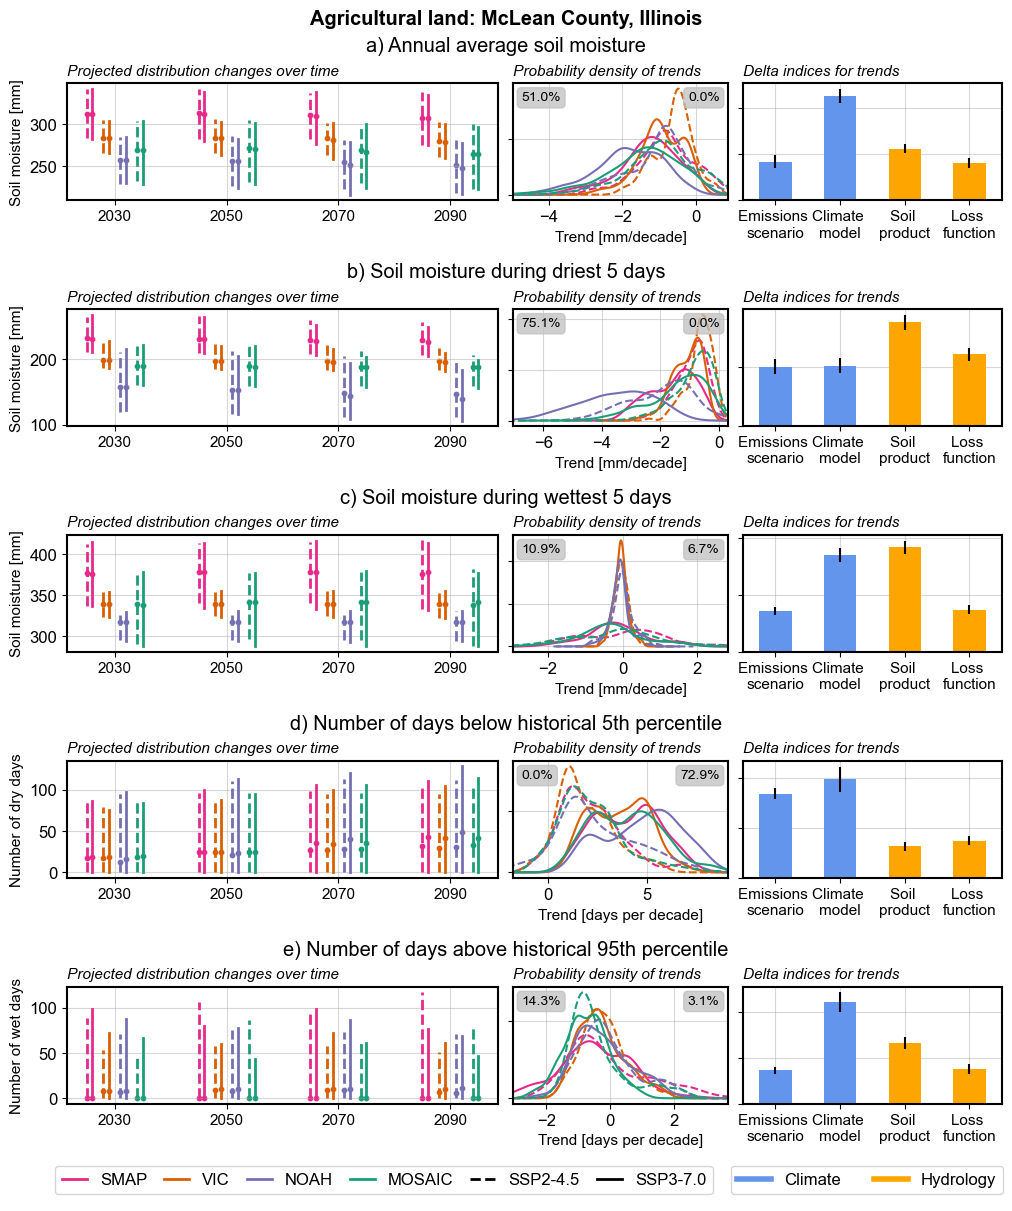

In [16]:
location_name = 'mclean'
sa_factors = ['ssp', 'model', 'obs_name', 'loss_metric']
save_path = f'../figs/main/fig7_trends_{location_name}_sa.pdf'

trend_plot_single_loc(location_name, sa_factors, save_path)

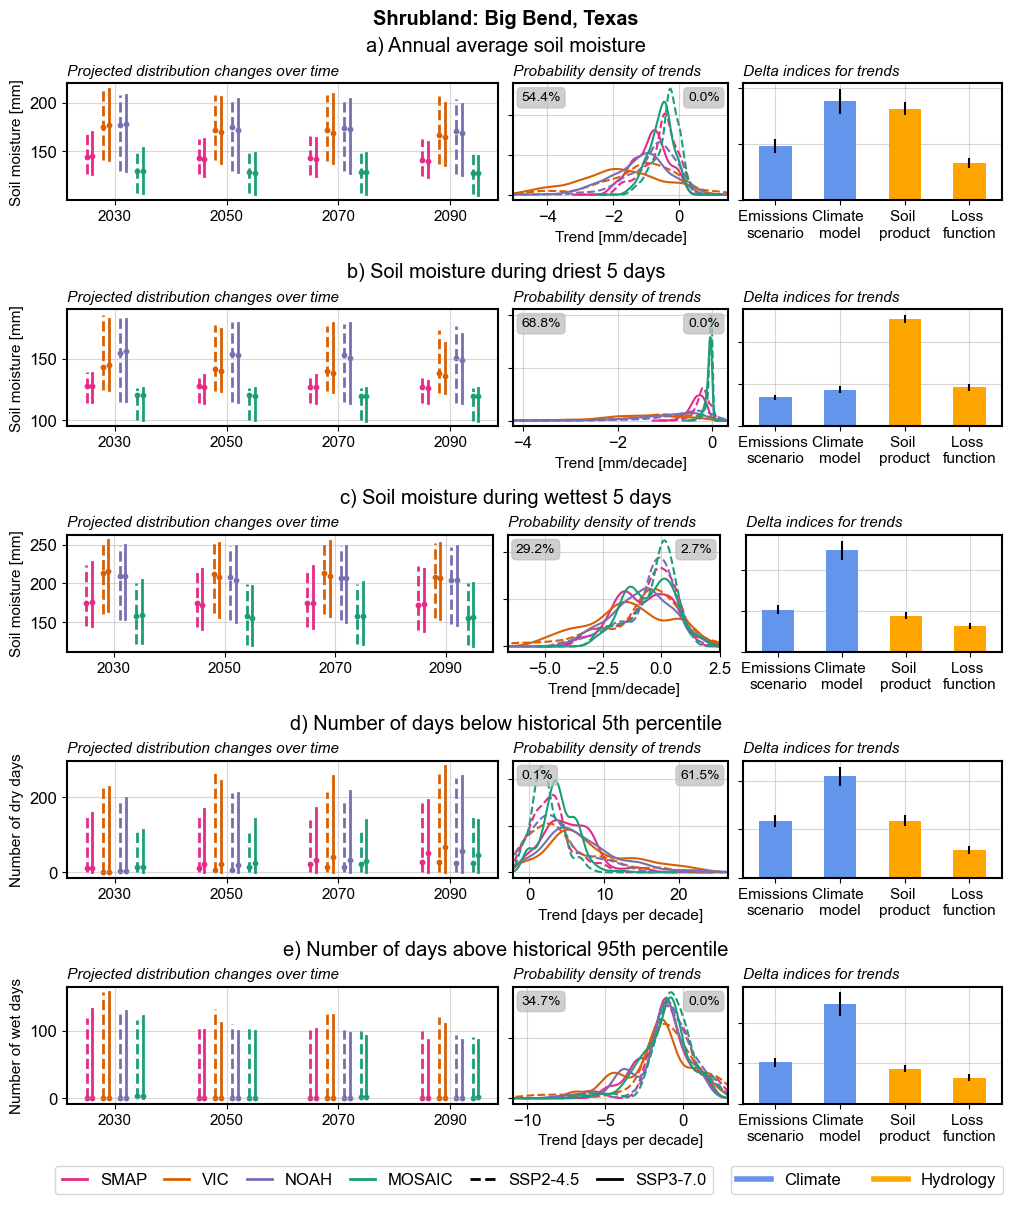

In [15]:
location_name = 'bigbend'
sa_factors = ['ssp', 'model', 'obs_name', 'loss_metric']
save_path = f'../figs/si/trends_{location_name}_sa.pdf'

trend_plot_single_loc(location_name, sa_factors, save_path)

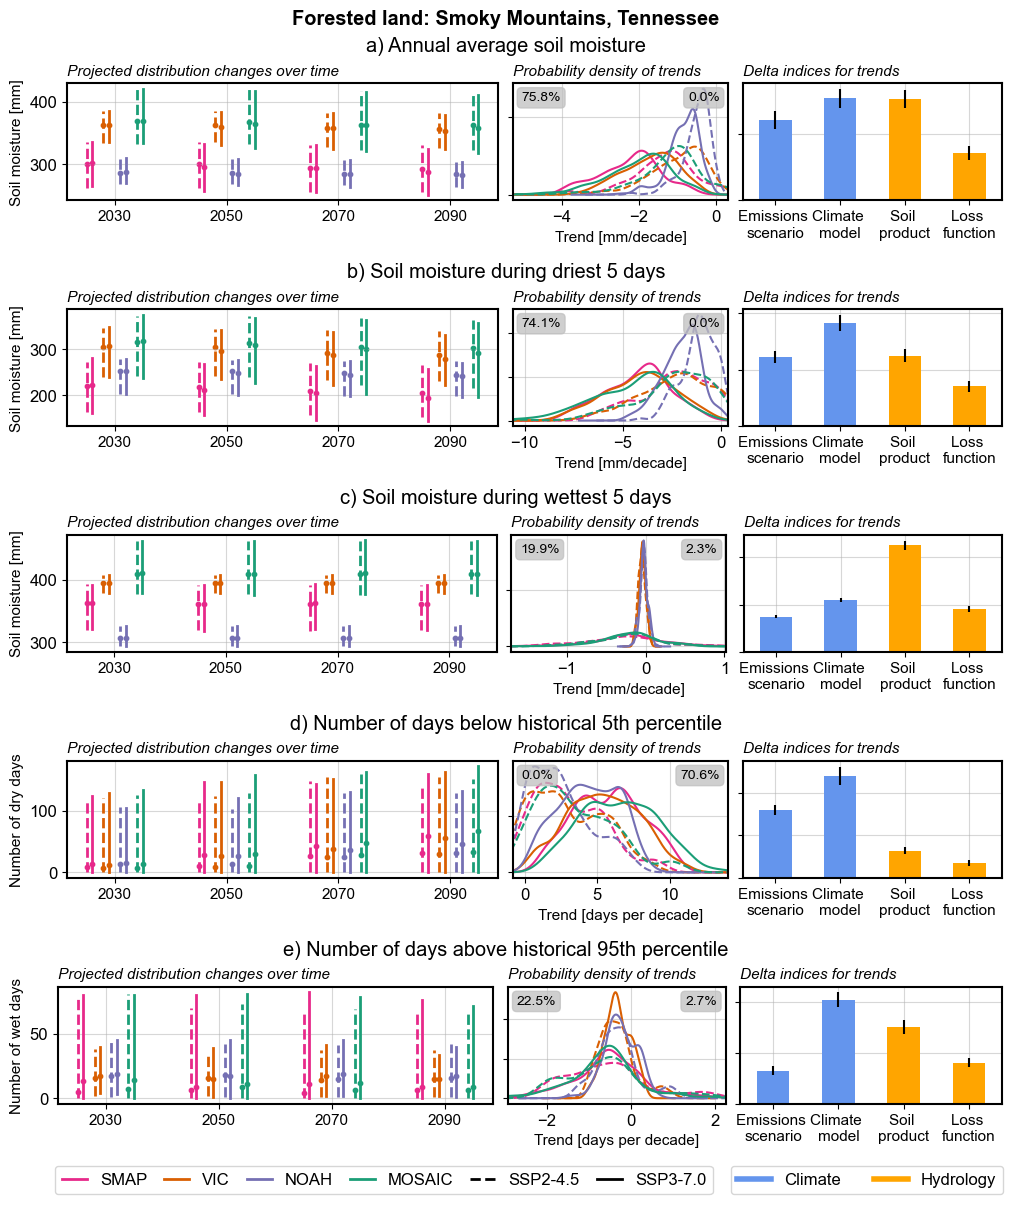

In [16]:
location_name = 'smoky'
sa_factors = ['ssp', 'model', 'obs_name', 'loss_metric']
save_path = f'../figs/si/trends_{location_name}_sa.pdf'

trend_plot_single_loc(location_name, sa_factors, save_path)

### Map: Figure 8

In [15]:
# Read trends
ds_trend_mean = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/mean_trend.nc')
ds_trend_5dmin = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/5dmin_trend.nc')
ds_trend_5dmax = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/5dmax_trend.nc')
ds_trend_q05 = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/days_below_q05_trend.nc')
ds_trend_q95 = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/days_above_q95_trend.nc')

# Read trend SA
# sa_type = 'soil_grouped'
# sa_factors = ['ssp', 'model', 'soil_id']

sa_type = 'all'
sa_factors = ['ssp', 'model', 'obs_name', 'loss_metric']

ds_trend_mean_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/mean_trends_delta-sa_{sa_type}.nc')
ds_trend_5dmin_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/5dmin_trends_delta-sa_{sa_type}.nc')
ds_trend_5dmax_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/5dmax_trends_delta-sa_{sa_type}.nc')
ds_trend_q05_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/days_below_q05_trends_delta-sa_{sa_type}.nc')
ds_trend_q95_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/days_above_q95_trends_delta-sa_{sa_type}.nc')

/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/storage/home/dcl5300/miniforg

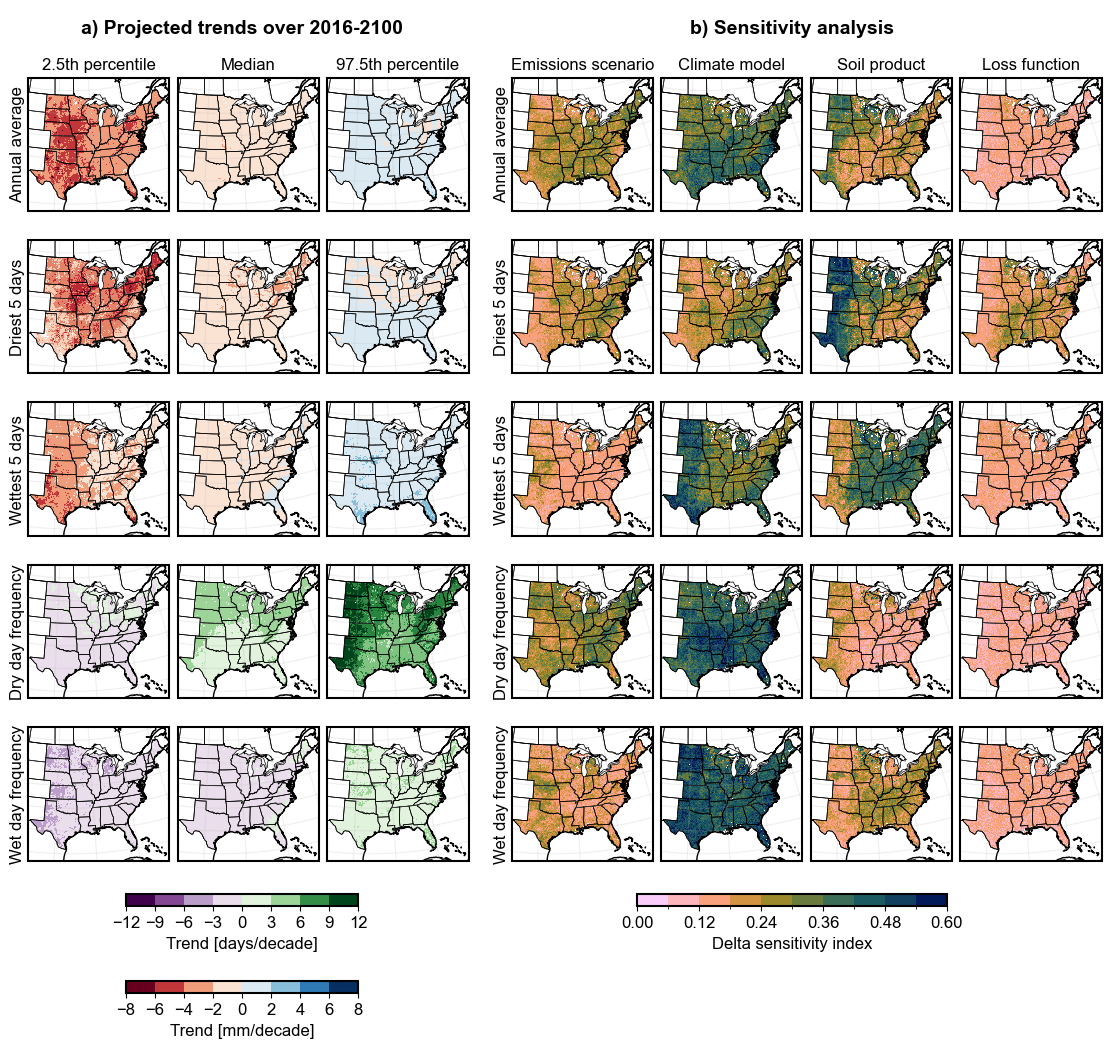

In [16]:
fig = plt.figure(layout = 'constrained', figsize=(11, 10))

subfigs = fig.subfigures(nrows=3, ncols=1, height_ratios=[0.5,10,1.5], wspace=0.01)

#### Titles
axs = subfigs[0].subplots(1,2, width_ratios=[3,4], gridspec_kw={'hspace':0.01, 'wspace':0.01})

axs[0].set_title('a) Projected trends over 2016-2100', fontweight='bold', y=0., fontsize=14)
axs[0].set_axis_off()

axs[1].set_title('b) Sensitivity analysis', fontweight='bold', y=0., fontsize=14)
axs[1].set_axis_off()

########## Trends
mm_vmin, mm_vmax = -8, 8
mm_cmap = 'RdBu'
days_vmin, days_vmax = -12, 12
days_cmap = 'PRGn'

axs = subfigs[1].subplots(5, 7, sharex=True, sharey=True,
                   subplot_kw=dict(projection=ccrs.LambertConformal()))

# Plot mm trends
p_mm = plot_quantiles([ds_trend_mean, ds_trend_5dmin, ds_trend_5dmax], mm_vmin, mm_vmax, mm_cmap, axs[:3,:3], True)

# Plot day trends
p_days = plot_quantiles([ds_trend_q05, ds_trend_q95], days_vmin, days_vmax, days_cmap, axs[3:5,:3], False)

# Metric labels
soil_labels_plot = ['mean-change', '5dmin-change', '5dmax-change', 'days_below_q05', 'days_above_q95']
for idl, soil_label in enumerate(soil_labels_plot):
    axs[idl,0].text(-0.075, 0.5, soil_labels_short[soil_label], horizontalalignment='center', fontsize=12,
                    rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)

############# SA
vmax = 0.6
cmap = sc_cmap

p = plot_sa_maps([ds_trend_mean_sa, ds_trend_5dmin_sa, ds_trend_5dmax_sa, ds_trend_q05_sa, ds_trend_q95_sa],
                 sa_factors, vmax, sc_cmap, axs[:,3:], split_labels=False)

# Metric labels
soil_labels_plot = ['mean-change', '5dmin-change', '5dmax-change', 'days_below_q05', 'days_above_q95']
for idl, soil_label in enumerate(soil_labels_plot):
    axs[idl,3].text(-0.13, 0.5, f'\n{soil_labels_short[soil_label]}', horizontalalignment='center', fontsize=12,
                    rotation=90, verticalalignment='center', transform=axs[idl,3].transAxes)
    
#### Cbars
axs = subfigs[2].subplots(1,2, width_ratios=[3,4], gridspec_kw={'hspace':0.01, 'wspace':0.01})

axs[0].set_axis_off()
axs[1].set_axis_off()

axins1 = inset_axes(axs[0], width="50%", height="10%", loc="upper center",)
subfigs[2].colorbar(p_days, orientation="horizontal", label="Trend [days/decade]", cax=axins1)

axins2 = inset_axes(axs[0],width="50%",height="10%",loc="lower center",)
subfigs[2].colorbar(p_mm, orientation="horizontal", label="Trend [mm/decade]", cax=axins2)

axins3 = inset_axes(axs[1], width="50%", height="10%",loc="upper center",)

subfigs[2].colorbar(p, orientation="horizontal", label="Delta sensitivity index", cax=axins3)

plt.savefig('../figs/main/fig8_trends_map_sa.png', dpi=600, bbox_inches='tight')

### Map: SI 

In [15]:
# Read trends
ds_trend_q01 = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/days_below_q01_trend.nc')
ds_trend_q99 = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics/days_above_q99_trend.nc')

# Read trend SA
sa_type = 'all'
sa_factors = ['ssp', 'model', 'obs_name', 'loss_metric']

ds_trend_q01_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/days_below_q01_trends_delta-sa_{sa_type}.nc')
ds_trend_q99_sa = xr.open_dataset(f'{project_data_path}/projections/{subset_name}/sa_results/days_above_q99_trends_delta-sa_{sa_type}.nc')

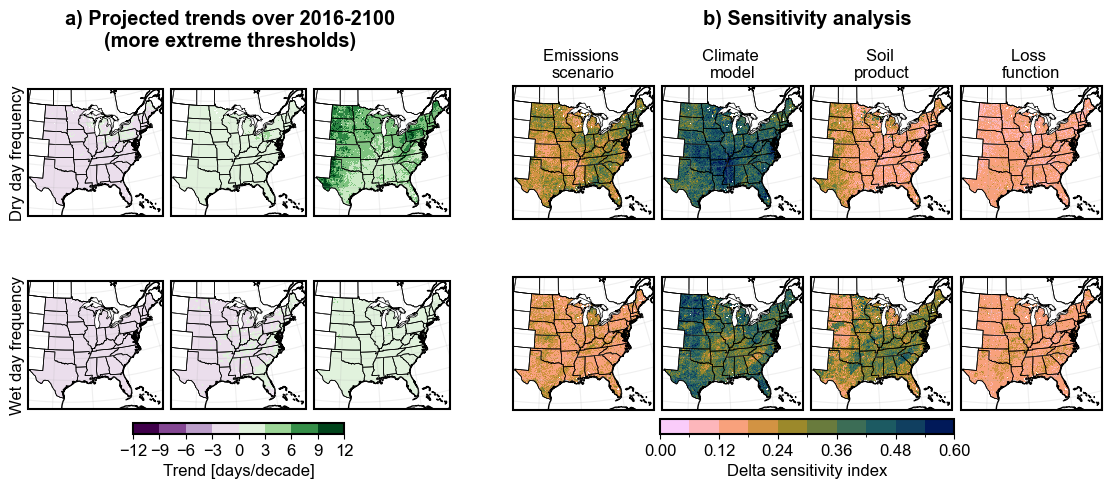

In [20]:
##### Plot
fig = plt.figure(layout = 'constrained', figsize=(11, 4.5))

width_ratios = [3,4] if sa_type == 'all' else [1.05,1]
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=width_ratios)

# Trends
mm_vmin, mm_vmax = -8, 8
mm_cmap = 'RdBu'
days_vmin, days_vmax = -12, 12
days_cmap = 'PRGn'

subfigs[0].suptitle('a) Projected trends over 2016-2100\n(more extreme thresholds)', fontweight='bold', y=1.05)
axs = subfigs[0].subplots(2, 3, sharex=True, sharey=True,
                   gridspec_kw=dict(wspace=0.01, hspace=0.01),
                   subplot_kw=dict(projection=ccrs.LambertConformal()))

# Plot day trends
p_days = plot_quantiles([ds_trend_q01, ds_trend_q99], days_vmin, days_vmax, days_cmap, axs, False)
            
# Metric labels
soil_labels_plot = ['days_below_q01', 'days_above_q99']
for idl, soil_label in enumerate(soil_labels_plot):
    axs[idl,0].text(-0.075, 0.5, soil_labels_short[soil_label], horizontalalignment='center', fontsize=12,
                    rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)
    
# Cbar
subfigs[0].colorbar(p_days,
             orientation="horizontal",
             label="Trend [days/decade]",
             ax=axs, pad=0.02, shrink=0.5)

############# SA
vmax = 0.6
cmap = sc_cmap

subfigs[1].suptitle('b) Sensitivity analysis', fontweight = 'bold', y=1.05)

axs = subfigs[1].subplots(2, len(sa_factors), sharex=True, sharey=True,
                   gridspec_kw=dict(wspace=0.01, hspace=0.01),
                   subplot_kw=dict(projection=ccrs.LambertConformal()))

p = plot_sa_maps([ds_trend_q01_sa, ds_trend_q99_sa], sa_factors, vmax, sc_cmap, axs)

# Cbar
subfigs[1].colorbar(p,
                    orientation="horizontal",
                    label="Delta sensitivity index",
                    ax=axs, pad=0.02, shrink=0.5)

plt.savefig('../figs/si/threshold_trends_map_sa.png', dpi=600, bbox_inches='tight')

# Changes from historical

### Functions

In [31]:
# Plot map of SA results
def make_sa_map_plot(soil_metrics, metric_type, time_slice, soil_sa, title, vmax, save_folder, cmap=sc_cmap, ysup=0.93):
    """
    Plots a map of Delta SA results for specified time period, metric, and SA grouping. 
    """

    if soil_sa == 'soil_grouped':
        sa_factors = ['ssp', 'model', 'time', 'soil_id']
        ncol = 4
        height = 3+2*len(soil_metrics)
    else:
        sa_factors = ['ssp', 'model', 'time', 'obs_name', 'loss_metric']
        ncol = 5
        height = 1+2*len(soil_metrics)
    
    # Read all
    ds_all = [xr.open_dataset(f'{project_data_path}/projections/eCONUS/sa_results/{metric}_{time_slice[0]}-{time_slice[1]}_delta-sa_{soil_sa}.nc') 
              for metric in soil_metrics]
    
    # Plot
    fig, axs = plt.subplots(len(soil_metrics), ncol, figsize=(9, height), sharex=True, sharey=True,
                            gridspec_kw=dict(wspace=0.1, hspace=0.01),
                            subplot_kw=dict(projection=ccrs.LambertConformal()))
    
    p = plot_sa_maps(ds_all, sa_factors, vmax, cmap, axs)
    
    # Metrics
    for idl, metric in enumerate(soil_metrics):
        axs[idl,0].text(-0.075, 0.5, soil_labels_short[metric], horizontalalignment='center', fontsize=12,
                        rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)
    
    # Cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Delta sensitivity index",
                 ax=axs, pad=0.02, shrink=0.5)

    # Title
    if title is not None:
        fig.suptitle(title, fontweight='bold', y=ysup)
    
    # Store
    savepath = f'../figs/{save_folder}/{metric_type}_sa_{time_slice[0]}-{time_slice[1]}_{soil_sa}.png'
    plt.savefig(savepath, dpi=600, bbox_inches='tight')

## Figure 9

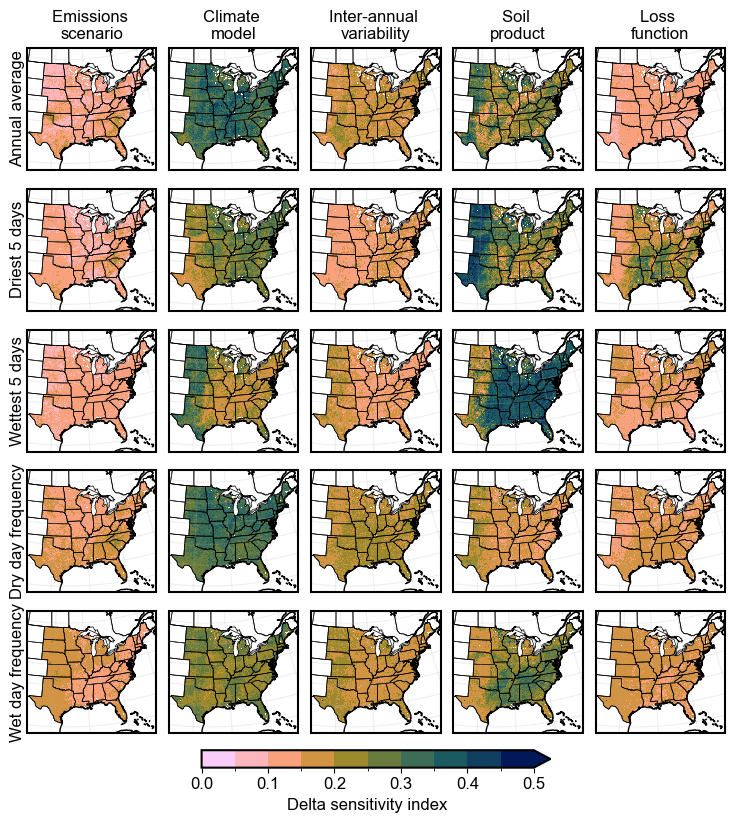

In [90]:
soil_metrics = ['mean-change', '5dmin-change', '5dmax-change', 'days_below_q05', 'days_above_q95']
metric_type = 'fig9'
save_folder = 'main'
soil_sa = 'all'
vmax = 0.5
time_slice = time_slices[1]
title = None

make_sa_map_plot(soil_metrics, metric_type, time_slice, soil_sa, title, vmax, save_folder)

## SI maps

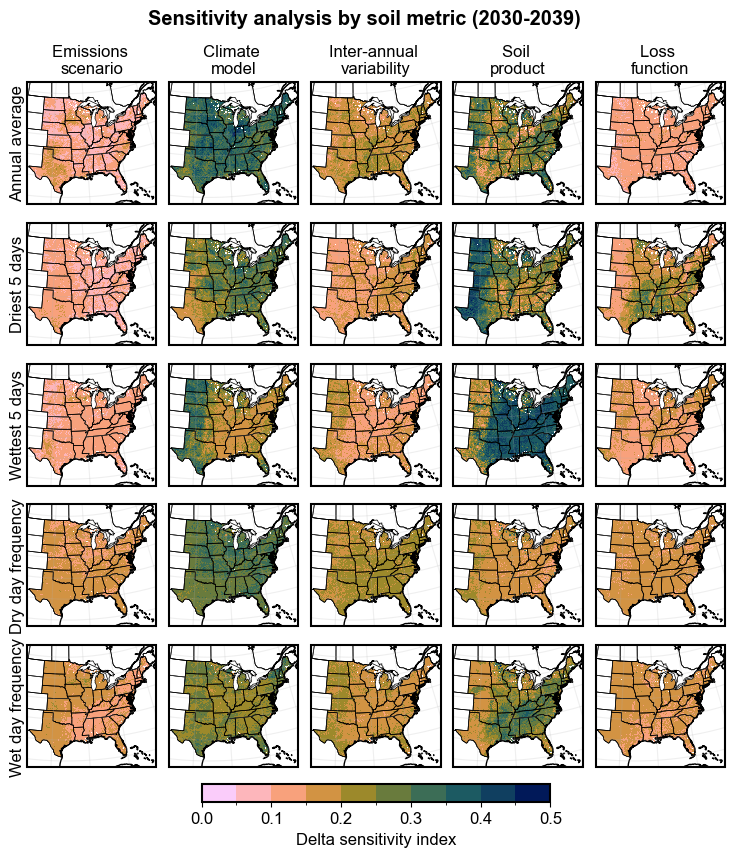

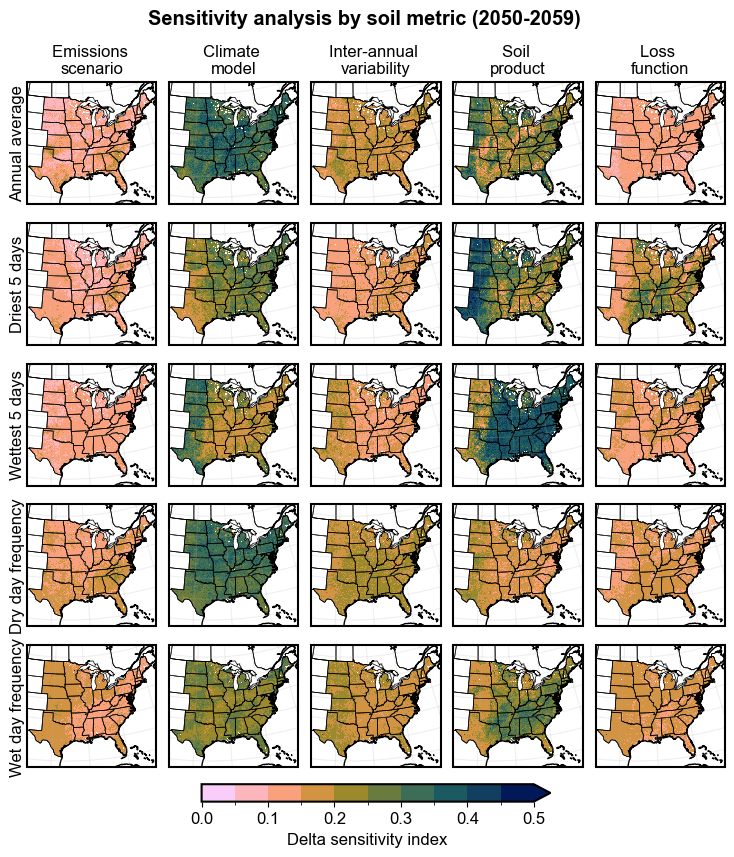

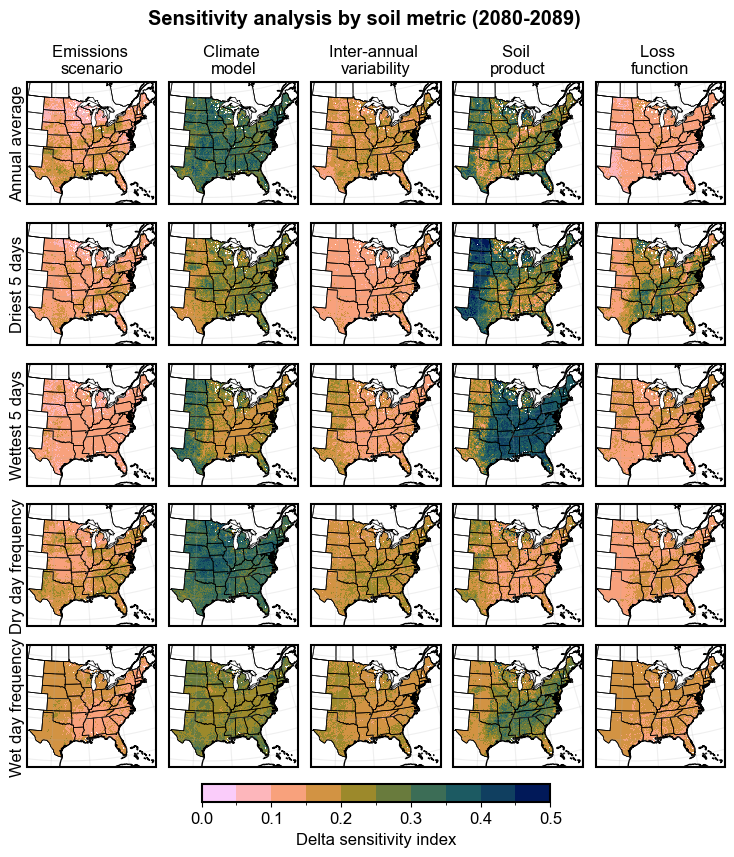

In [91]:
# Loop through all: changes
soil_metrics = ['mean-change', '5dmin-change', '5dmax-change', 'days_below_q05', 'days_above_q95']
metric_type = 'change'
save_folder = 'si'
vmax = 0.5
soil_sa = 'all'

for time_slice in time_slices:
    title = f'Sensitivity analysis by soil metric ({time_slice[0]}-{time_slice[1]})'
    make_sa_map_plot(soil_metrics, metric_type, time_slice, soil_sa, title, vmax, save_folder)

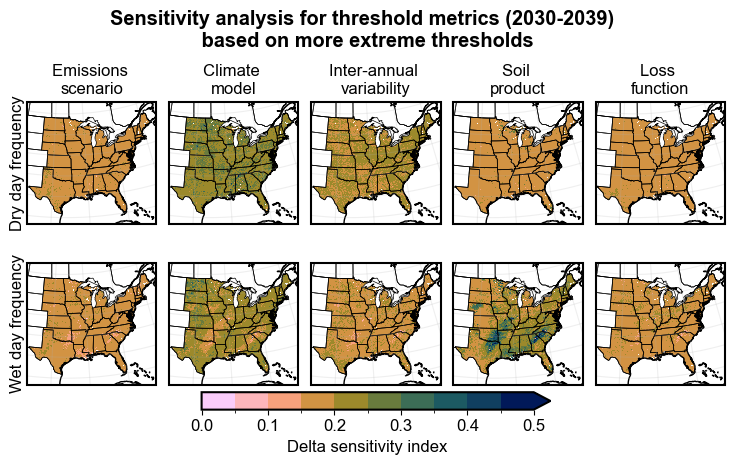

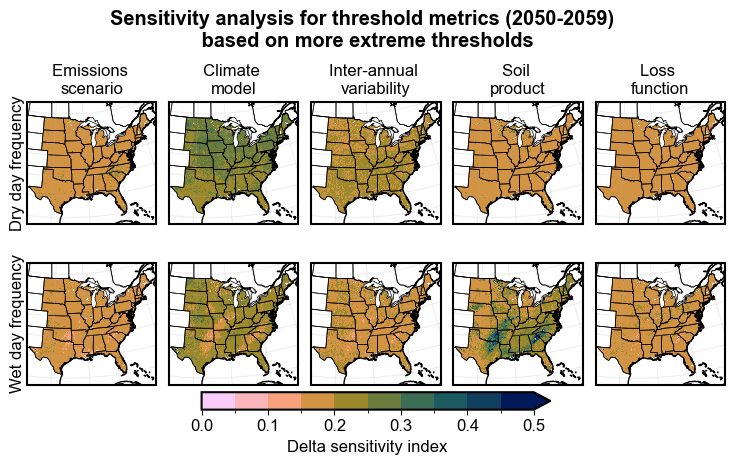

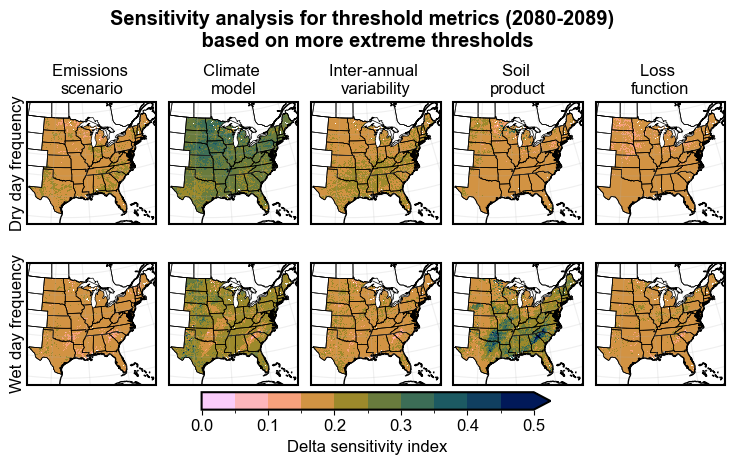

In [95]:
# Loop through all: changes
soil_metrics = ['days_below_q01', 'days_above_q99']
metric_type = 'change_highthresh'
save_folder = 'si'
vmax = 0.5
soil_sa = 'all'

for time_slice in time_slices:
    title = f'Sensitivity analysis for threshold metrics ({time_slice[0]}-{time_slice[1]}) \n based on more extreme thresholds'
    make_sa_map_plot(soil_metrics, metric_type, time_slice, soil_sa, title, vmax, save_folder, ysup=0.99)

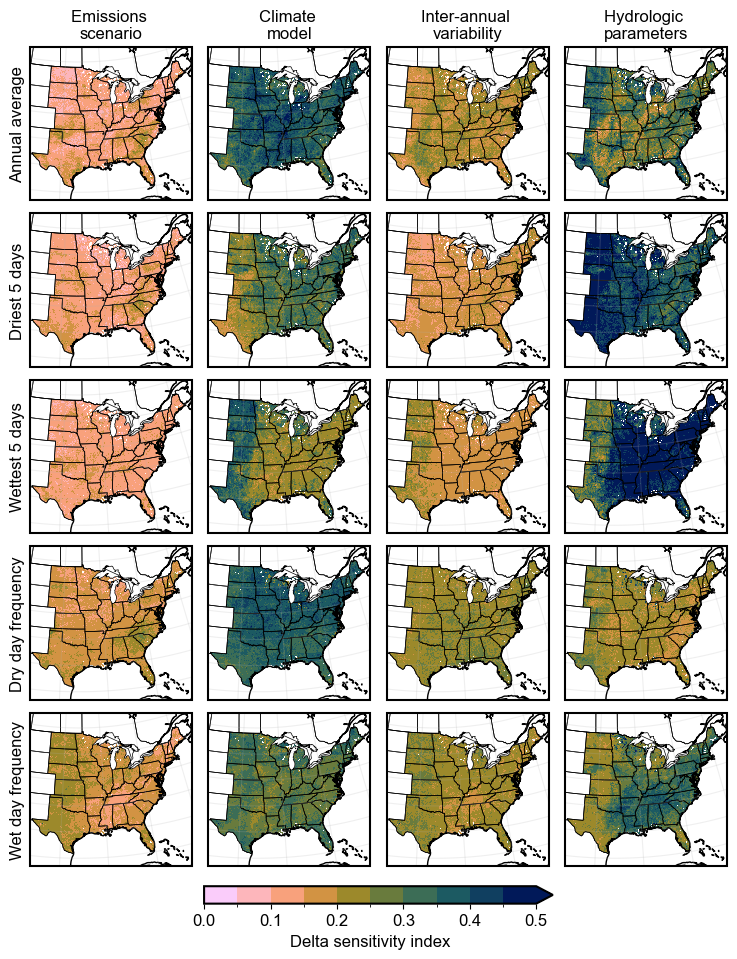

In [32]:
soil_metrics = ['mean-change', '5dmin-change', '5dmax-change', 'days_below_q05', 'days_above_q95']
metric_type = 'change'
save_folder = 'si'
soil_sa = 'soil_grouped'
vmax = 0.5
time_slice = time_slices[1]
title = None

make_sa_map_plot(soil_metrics, metric_type, time_slice, soil_sa, title, vmax, save_folder)

## SI single gridpoints

In [45]:
def plot_single_gridpoint_pdf_sa(soil_metrics, time_slice, lat, lon, title, save_str):
    """
    """
    # Read all for PDF
    _load_combined_metrics = lambda metric, time_slice, lat, lon: xr.open_dataset(f'{project_data_path}/projections/{subset_name}/metrics_combined/{metric}_{time_slice[0]}-{time_slice[1]}.nc').sel(lat=lat, lon=lon, method='nearest')
    ds_all = [_load_combined_metrics(metric, time_slice, lat, lon) for metric in soil_metrics]

    fig = plt.figure(layout='constrained', figsize=(14, 12))
    subfigs = fig.subfigures(len(soil_metrics), 1)

    # Loop through metrics for PDF
    for idm, soil_metric in enumerate(soil_metrics):
        # Plot all PDFs
        subfigs[idm].suptitle(soil_labels[soil_metric].replace('\n', ''), fontsize=12)
        sub_axs = subfigs[idm].subplots(1, len(sa_factors)+1)
            
        df = ds_all[idm].to_dataframe().reset_index()
        xmin, xmax = df[soil_metric].min(), df[soil_metric].max()
        
        for idf, factor in enumerate(sa_factors):
            ax = sub_axs[idf]
            df.groupby(factor)[soil_metric].plot.kde(ax=ax, lw=3, color='silver') # factor
            df[soil_metric].plot.kde(ax=ax, color='black', lw=2) # main
            # Tidy
            ax.grid(alpha=0.2)
            ax.set_yticklabels([])
            ax.set_xlim(xmin, xmax)
            ax.set_ylabel('Density' if idf == 0 else '', fontsize=11)
            ax.set_title(index_labels_single[factor].replace('\n','') if idm == 0 else '', fontsize=11)
                
        # Plot SA
        Si = get_delta_single(df, soil_metric, sa_factors)
        xlabels = True if idm == len(soil_metrics)-1 else False
        legend = True if idm == 0 else False
        ax = sub_axs[-1]
        plot_sa_single(Si, sa_factors, climate_color, hydro_color, legend, True, xlabels, -30, 11, ax, index_labels=index_labels_simple)
        ax.set_title('Sensitivity analysis' if idm == 0 else '', fontsize=11)
        ax.tick_params(axis='x', labelsize=10)
            
    # Save
    fig.suptitle(title, fontweight='bold', fontsize=12)
    plt.savefig(f'../figs/si/{save_str}.pdf')

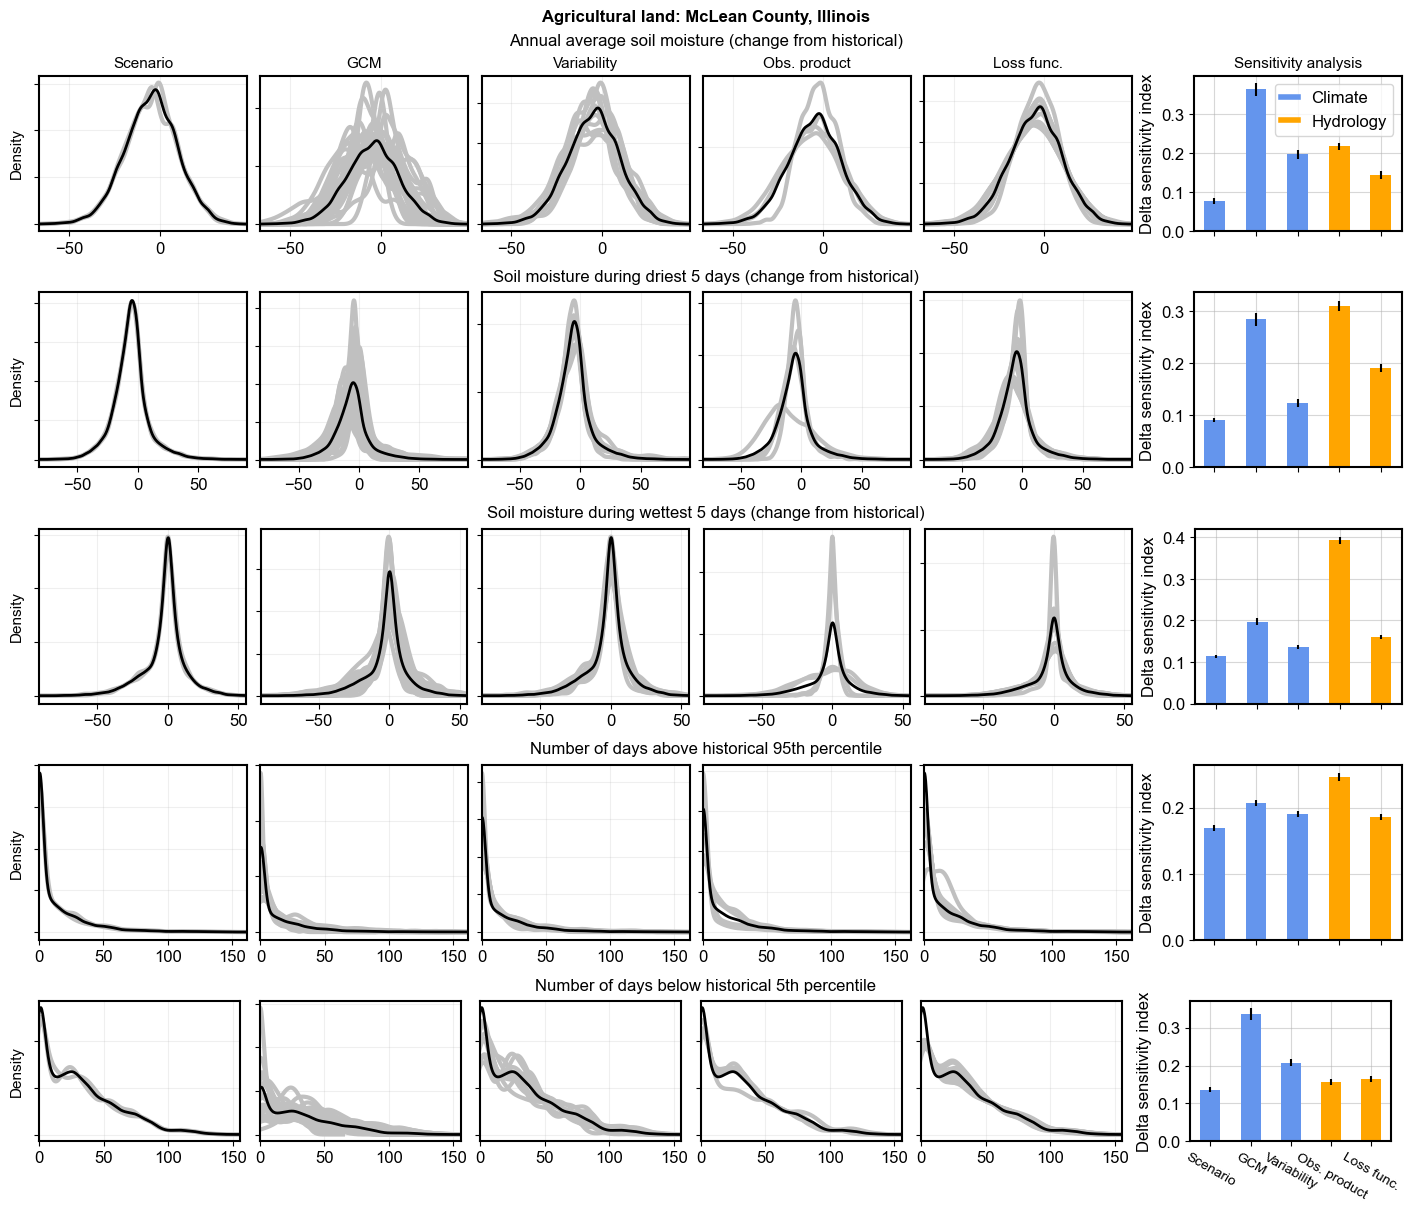

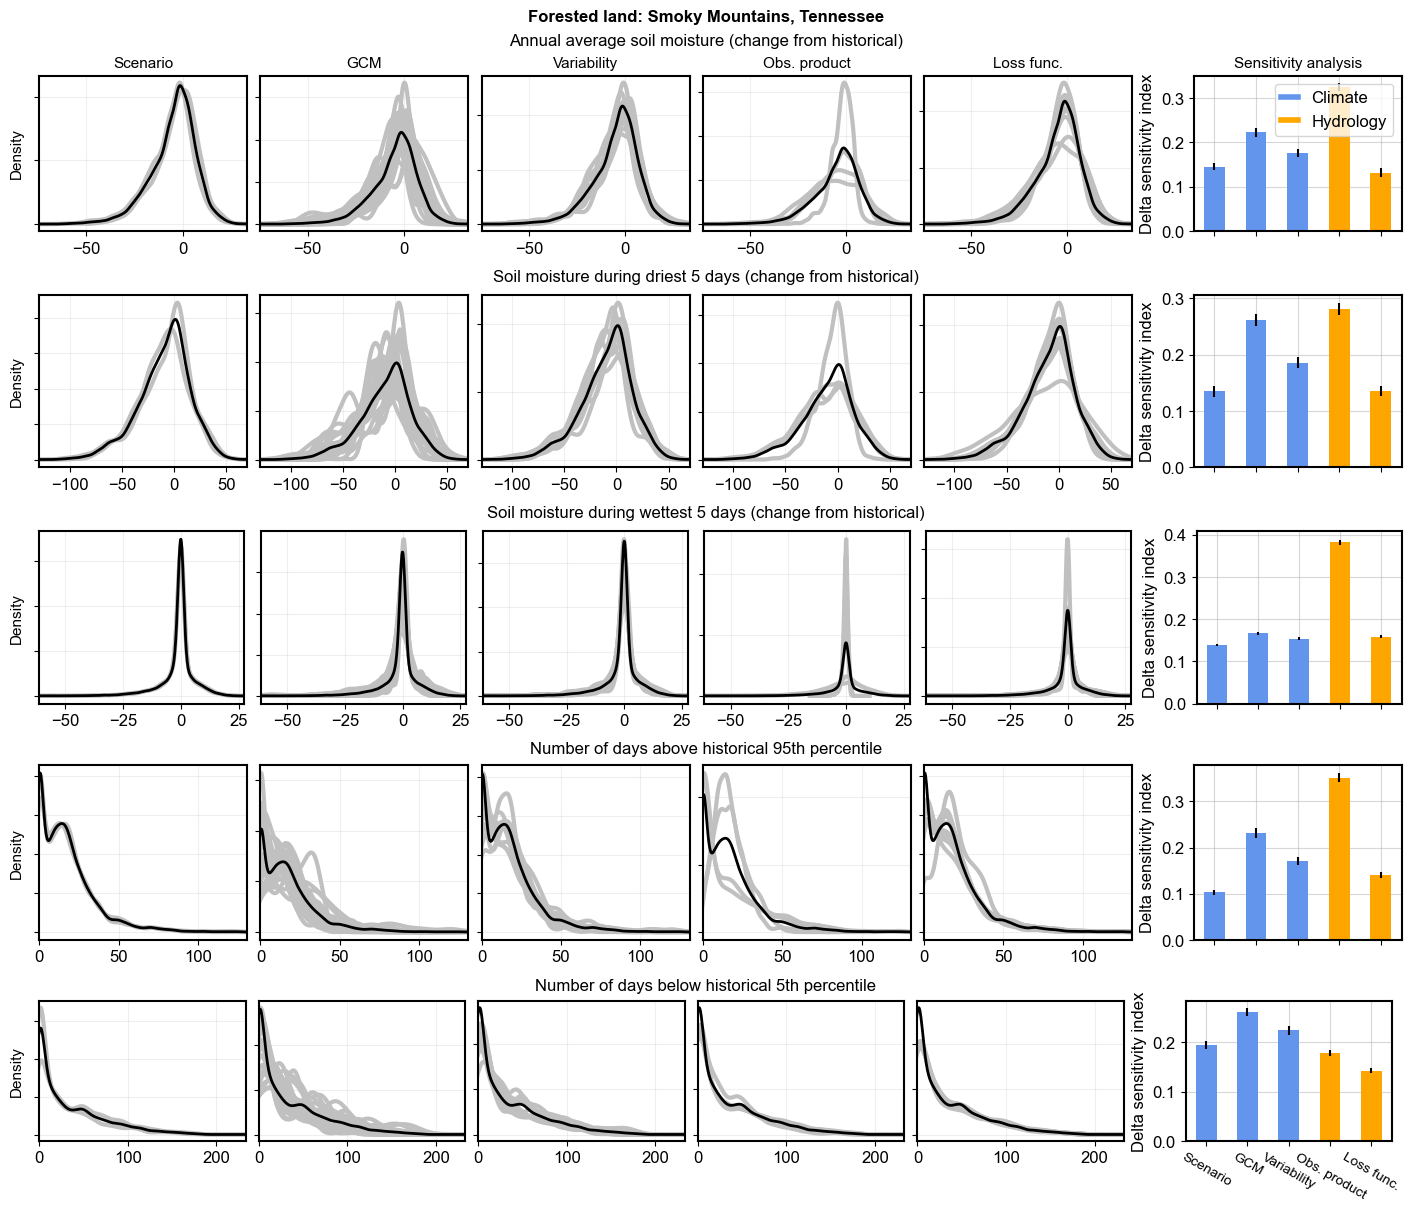

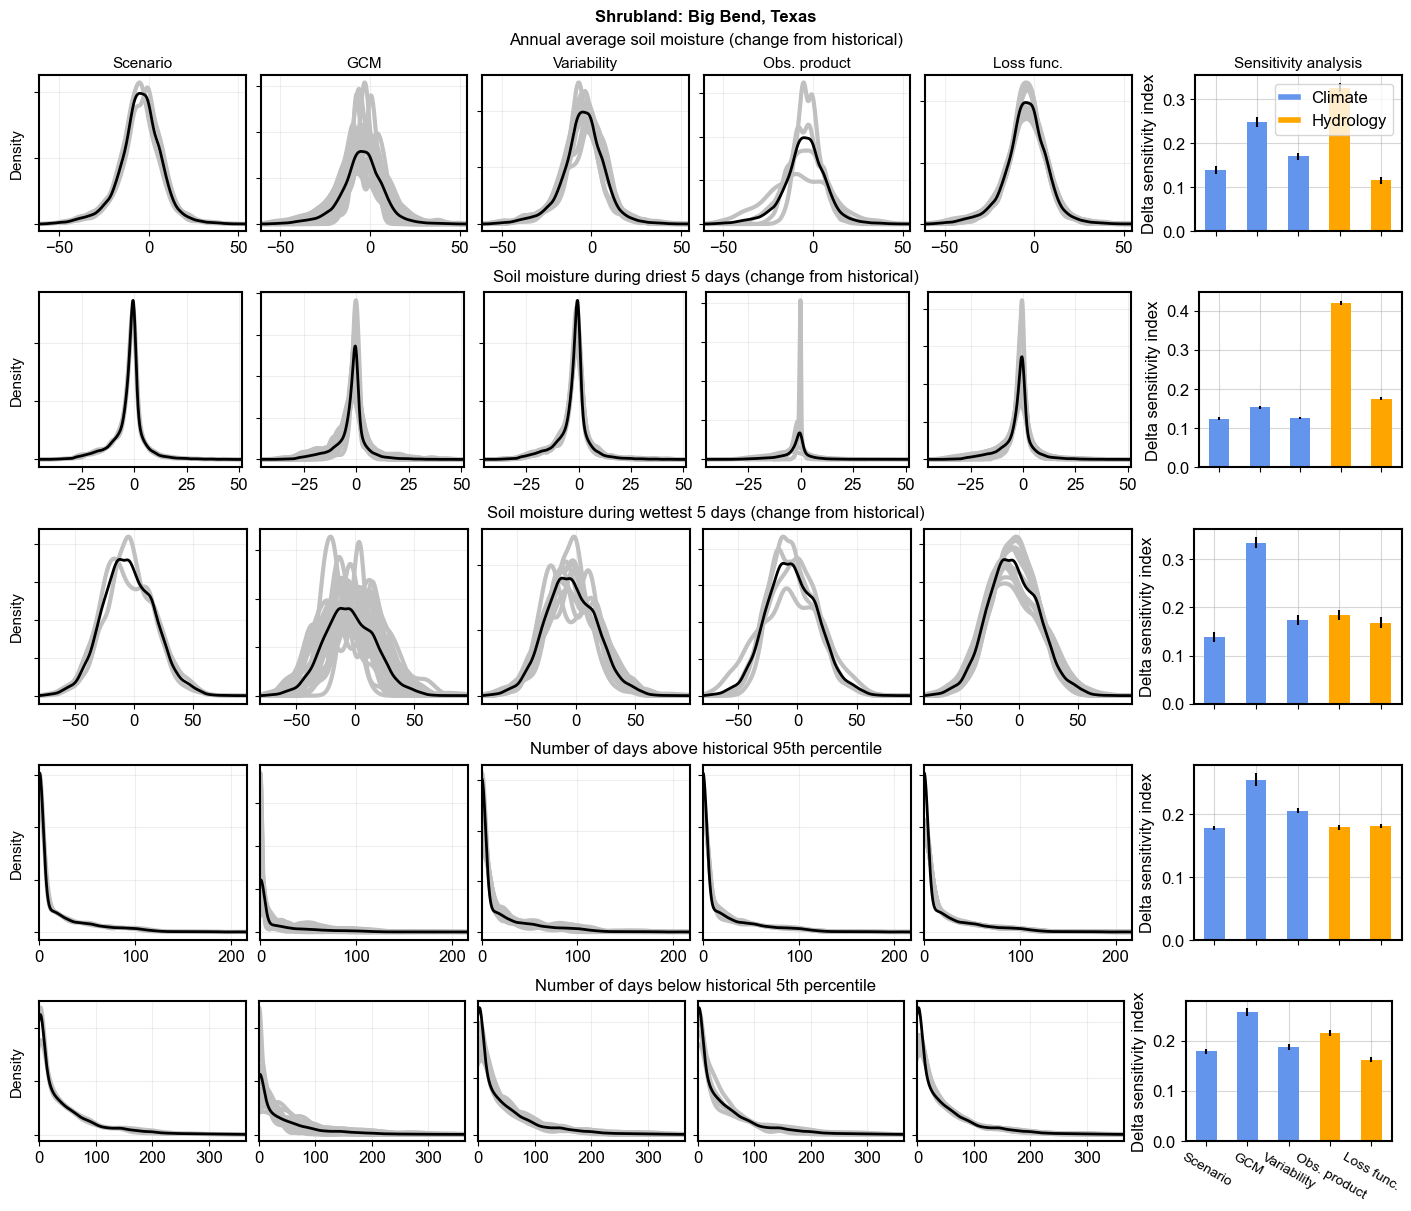

In [46]:
# Make all plots
soil_metrics = ['mean-change', '5dmin-change', '5dmax-change', 'days_above_q95', 'days_below_q05']
time_slice = time_slices[1]

sa_factors = ['ssp', 'model', 'time', 'obs_name', 'loss_metric']

for location_name in location_names:
    lat, lon = location_coords[location_name]
    title = location_names[location_name]
    save_str = f'{location_name}_pdf_sa_{time_slice[0]}-{time_slice[1]}'
    plot_single_gridpoint_pdf_sa(soil_metrics, time_slice, lat, lon, title, save_str)